# Study on epistemic uncertainty in polyp segmentation from gastrointestinal tract images

This notebook associates the white paper I wrote on epistemic uncertainty as part of my Master of Science at the Eindhoven Univerisity of Technology. <br>Jort de Jong

In [ ]:
kvasir_dataset_path = 'drive/My Drive/Kvasir-SEG/'
cvc_dataset_path = 'drive/My Drive/CVC-ClinicDB/'

image_res_aug = (136, 136)      #Max 288 by 288
image_resolution = (128, 128)

nr_mc_samples = 100

### sources

Some sources I used throughout the project:
- https://datasets.simula.no/kvasir-seg/
- https://www.kaggle.com/balraj98/cvcclinicdb?select=PNG
- https://www.programmersought.com/article/16144808261/
- https://github.com/tatsy/normalizing-flows-pytorch/blob/master/main.py
- https://discuss.pytorch.org/t/bayesian-deep-learning-with-monte-carlo-dropout-pytorch/93815
- https://www.depends-on-the-definition.com/model-uncertainty-in-deep-learning-with-monte-carlo-dropout/

### Imports

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
import os
import random
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
import torch
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

Device used: cuda:0


## Dataset processing

In [ ]:
class Polyp(Dataset):
    def __init__(self, image_path, label_path, samples, aug, resize_shape, noise_level=0):
        self.resize_shape = resize_shape
        self.noise_level = noise_level

        if aug==None:
            self.transform = self.to_tensor
            resize_image = T.Resize(resize_shape, interpolation=T.InterpolationMode.BILINEAR)
            resize_label = T.Resize(resize_shape, interpolation=T.InterpolationMode.NEAREST)
        else:
            self.transform = self.augmentation
            resize_image = T.Resize(aug, interpolation=T.InterpolationMode.BILINEAR)
            resize_label = T.Resize(aug, interpolation=T.InterpolationMode.NEAREST)

        self.samples = []

        #Load all images into memory
        for sample in tqdm(samples):
            image = Image.open(image_path + sample)
            image = resize_image(image)

            label = Image.open(label_path + sample).convert('1')
            label = resize_label(label)

            self.samples.append((image, label))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        (image, label) = self.samples[idx]
        image, label = self.transform(image, label)

        #Add noise
        image += torch.randn(image.size()) * self.noise_level
        image = image / (1 + self.noise_level)

        return image, label

    def to_tensor(self, image, label):
        image = T.ToTensor()(image)
        label = T.ToTensor()(label)

        return image, label

    def augmentation(self, image, label):
        i, j, h, w = T.RandomCrop.get_params(image, self.resize_shape)
        image = T.functional.crop(image, i, j, h, w)
        label = T.functional.crop(label, i, j, h, w)

        image = T.ColorJitter(0.05, 0.05, 0.05, 0.05)(image)

        if torch.rand(1) < 0.15:
            image = T.functional.hflip(image)
            label = T.functional.hflip(label)

        if torch.rand(1) < 0.15:
            image = T.functional.vflip(image)
            label = T.functional.vflip(label)

        image, label = self.to_tensor(image, label)

        return image, label

### Kvasir-SEG dataset processing

In [ ]:
#Use list comphresion instead?
samples = os.listdir(kvasir_dataset_path + 'images/')

In [ ]:
#Get all Kvasir-SEG samples and split them
samples = os.listdir(kvasir_dataset_path + 'images/')

train_samples, test_samples = train_test_split(samples, test_size=0.1)
train_samples, val_samples = train_test_split(train_samples, test_size=(1/9))

In [ ]:
#Create Kvasir-SEG datasets
kvasir_paths = (kvasir_dataset_path + 'images/', kvasir_dataset_path + 'masks/')

train_dataset = Polyp(*kvasir_paths, train_samples, None, image_resolution)
train_dataset_aug = Polyp(*kvasir_paths, train_samples, image_res_aug, image_resolution)
val_dataset = Polyp(*kvasir_paths, val_samples, None, image_resolution)
test_dataset = Polyp(*kvasir_paths, test_samples, None, image_resolution)

100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


In [ ]:
#Build DataLoaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2, prefetch_factor=25)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=50, shuffle=True, num_workers=2, prefetch_factor=25)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)

### CVC-Clinic dataset processing

In [ ]:
#Get all CVC-CLinic samples and split them
samples = os.listdir(cvc_dataset_path + 'Original/')

train_samples, test_samples = train_test_split(samples, test_size=(100/612))
train_samples, val_samples = train_test_split(train_samples, test_size=(100/512))

In [ ]:
#Create CVC-CLinic datasets
cvc_paths = (cvc_dataset_path + 'Original/', cvc_dataset_path + 'Ground Truth/')

cvc_train_dataset = Polyp(*cvc_paths, train_samples, None, image_resolution)
cvc_val_dataset = Polyp(*cvc_paths, val_samples, None, image_resolution)
cvc_test_dataset = Polyp(*cvc_paths, test_samples, None, image_resolution)
cvc_noise_dataset = Polyp(*cvc_paths, test_samples, None, image_resolution, noise_level=0.08)

100%|██████████| 100/100 [00:00<00:00, 123.58it/s]


In [ ]:
#Build DataLoaders
cvc_train_loader = DataLoader(cvc_train_dataset, batch_size=50, shuffle=True, num_workers=2, prefetch_factor=25)
cvc_val_loader = DataLoader(cvc_val_dataset, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)
cvc_test_loader = DataLoader(cvc_test_dataset, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)
cvc_noise_loader = DataLoader(cvc_noise_dataset, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)

### Visualizing

In [ ]:
def show_sample(dataset, idx=None):
    if idx==None:
        idx = random.randint(0, len(dataset))

    image, label = dataset[idx]

    f, axarr = plt.subplots(1, 2, figsize=(20, 10))
    axarr[0].imshow(T.functional.to_pil_image(image))
    axarr[0].set_title("Image")
    axarr[0].axis('off')
    axarr[1].imshow(T.functional.to_pil_image(label), cmap='gray')
    axarr[1].set_title("Label")
    axarr[1].axis('off')
    plt.show()

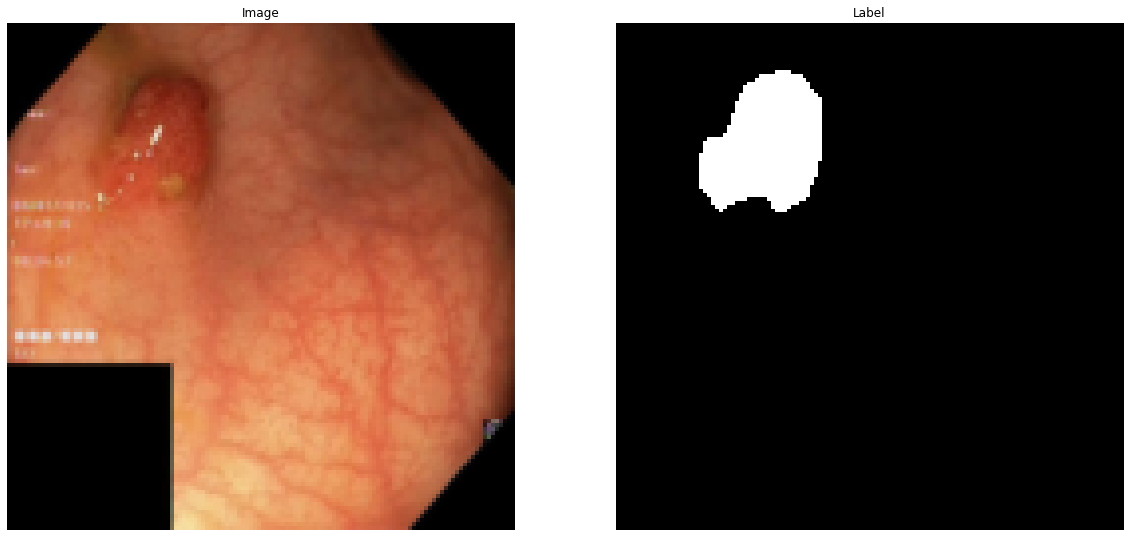

In [ ]:
#Show a sample of the Kvasir-SEG dataset
show_sample(val_dataset)

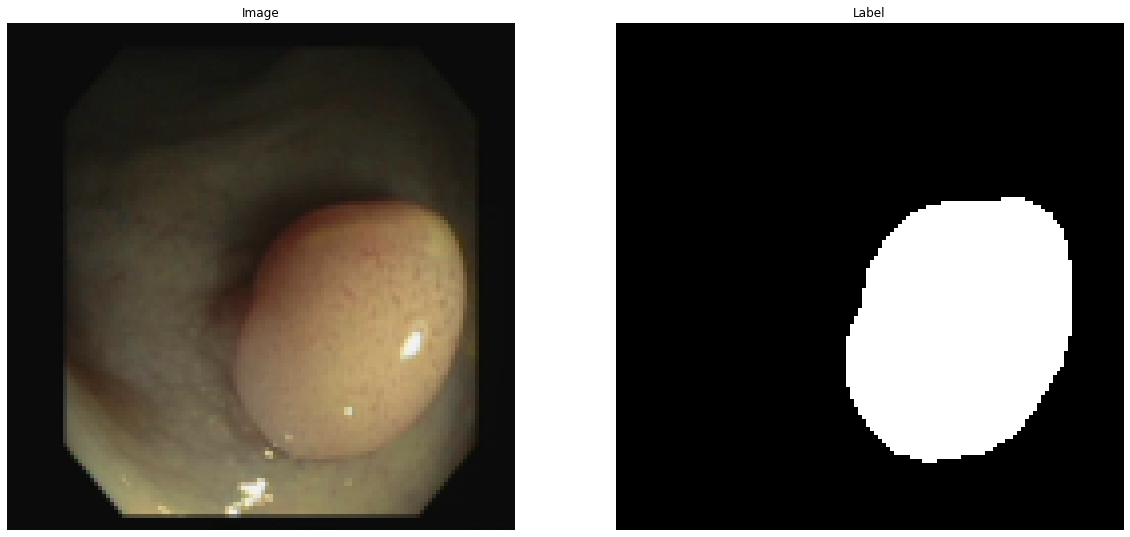

In [ ]:
#Show a sample of the CVC dataset
show_sample(cvc_val_dataset)

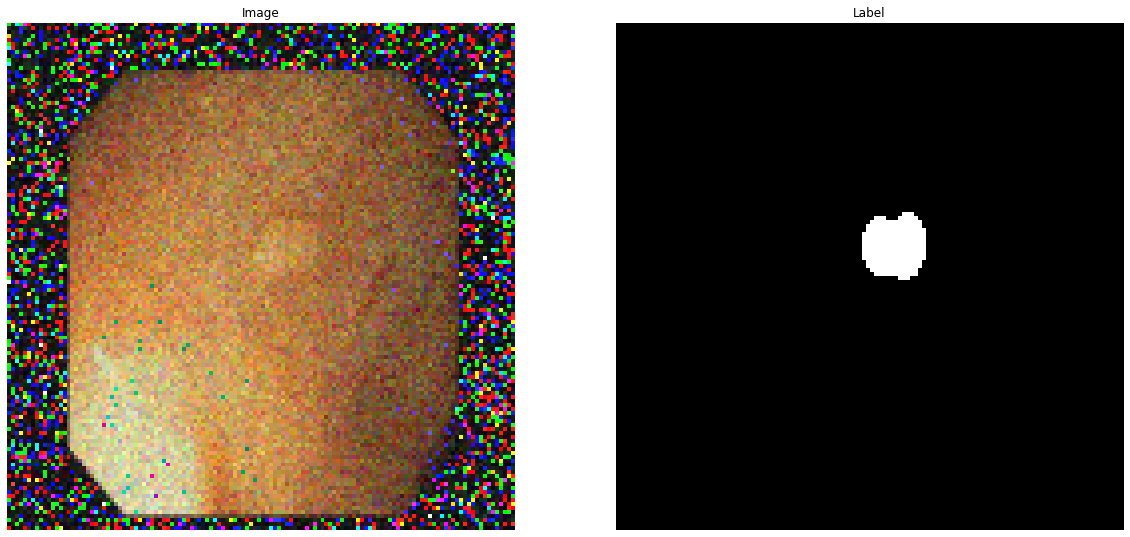

In [ ]:
#Show a sample of the CVC dataset with added noise
show_sample(cvc_noise_dataset)

## Segmentation model

### Training functions

In [ ]:
class Segmentation_model(nn.Module):
    """Adds an extra Dropout layer to the DeepLabV3 model
    """
    def __init__(self, p=0.4):
        super(Segmentation_model, self).__init__()

        self.model = deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=1)
        self.model.classifier[4] = nn.Sequential(torch.nn.Dropout(p=p, inplace=False),
                                                 torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)))

    def forward(self, x):
        return self.model(x)['out']

In [ ]:
def dice_scores(model, data_loader):
    model.eval()
    dice_list = []

    with torch.no_grad():
        for image, labels in data_loader:
            image, labels = image.to(device), labels.to(device)

            output = model(image)

            for pred, label in zip(output, labels):
                dice = dice_coeff(pred, label)
                dice_list.append(float(dice.cpu()))

    return dice_list

In [ ]:
def dice_coeff(pred, label, smooth=1e-5):
    pred = nn.Sigmoid()(pred)

    N = label.size(0)
    pred_flat = pred.view(N, -1)
    label_flat = label.view(N, -1)

    intersection = (pred_flat * label_flat).sum(1)
    unionset = pred_flat.sum(1) + label_flat.sum(1)
    loss = (2 * intersection + smooth) / (unionset + smooth)

    return loss.sum() / N

In [ ]:
def train(model, nr_epochs, loss_function, optimizer, callback=4, train_loader=train_loader_aug, val_loader=val_loader):
    train_loss = []
    train_dice = []
    val_loss = []
    val_dice = []

    max_val_dice = 0
    dice_not_increased = 0

    model.train()

    for epoch in range(nr_epochs):
        #Callback
        if dice_not_increased < callback:

            epoch_train_loss = []
            epoch_train_dice = []

            #Training set
            for image, label in train_loader:
                image, label = image.to(device), label.to(device)

                output = model(image)

                loss = loss_function(output, label)
                epoch_train_loss.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                dice = dice_coeff(output, label)
                epoch_train_dice.append(float(dice))


            train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
            train_dice.append(sum(epoch_train_dice) / len(epoch_train_dice))

            if epoch%5==0:
                print(f"\tEpoch: {epoch + 1}, \ttrain loss: {round(train_loss[-1], 2)}, \ttrain dice coefficent: {round(train_dice[-1] * 100, 2)}%")


            epoch_val_loss = []
            epoch_val_dice = []

            #Validation set
            with torch.no_grad():
                for image, label in val_loader:
                    image, label = image.to(device), label.to(device)
                    output = model(image)

                    loss = loss_function(output, label)
                    epoch_val_loss.append(loss.item())

                    dice = dice_coeff(output, label)
                    epoch_val_dice.append(float(dice))

            val_loss.append(sum(epoch_val_loss) / len(epoch_val_loss))
            val_dice.append(sum(epoch_val_dice) / len(epoch_val_dice))

            if epoch%5==0:
                print(f"\tEpoch: {epoch + 1}, \tval loss: {round(val_loss[-1], 2)}, \tval dice coefficent: {round(val_dice[-1] * 100, 2)}%")

            #Callback
            if val_dice[-1] > max_val_dice:
                max_val_dice = val_dice[-1]
                dice_not_increased = 0
            else:
                dice_not_increased += 1


    return train_loss, train_dice, val_loss, val_dice

### Train model

In [ ]:
model = Segmentation_model().to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
#Load segmentation model weights
model.load_state_dict(torch.load('/content/segmentation_model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
#Train segmentation model instead
train_loss, train_dice, val_loss, val_dice = train(model, 100, loss_function, optimizer, callback=5, train_loader=train_loader_aug)

	Epoch: 1, 	train loss: 0.43, 	train dice coefficent: 34.74%
	Epoch: 1, 	val loss: 0.27, 	val dice coefficent: 39.15%
	Epoch: 6, 	train loss: 0.13, 	train dice coefficent: 68.89%
	Epoch: 6, 	val loss: 0.14, 	val dice coefficent: 68.2%
	Epoch: 11, 	train loss: 0.1, 	train dice coefficent: 76.68%
	Epoch: 11, 	val loss: 0.09, 	val dice coefficent: 75.0%
	Epoch: 16, 	train loss: 0.08, 	train dice coefficent: 80.45%
	Epoch: 16, 	val loss: 0.1, 	val dice coefficent: 77.03%
	Epoch: 21, 	train loss: 0.07, 	train dice coefficent: 82.05%
	Epoch: 21, 	val loss: 0.08, 	val dice coefficent: 80.24%
	Epoch: 26, 	train loss: 0.06, 	train dice coefficent: 84.11%
	Epoch: 26, 	val loss: 0.07, 	val dice coefficent: 81.39%
	Epoch: 31, 	train loss: 0.07, 	train dice coefficent: 83.53%
	Epoch: 31, 	val loss: 0.07, 	val dice coefficent: 81.21%
	Epoch: 36, 	train loss: 0.05, 	train dice coefficent: 85.66%
	Epoch: 36, 	val loss: 0.06, 	val dice coefficent: 83.49%
	Epoch: 41, 	train loss: 0.05, 	train dice coeff

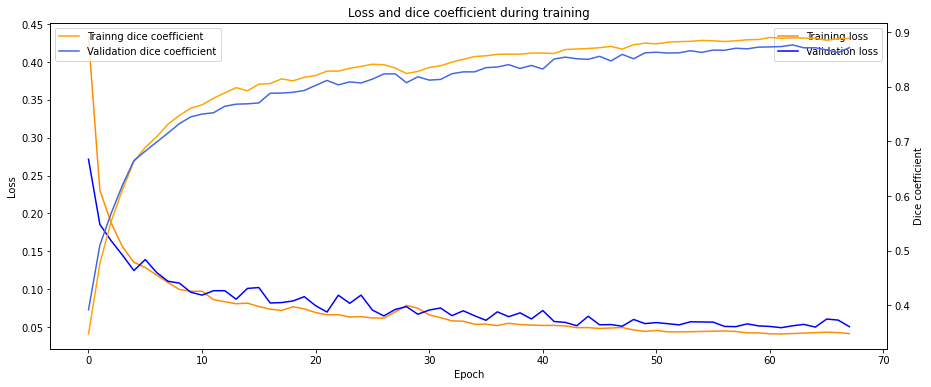

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 6))
plt.title("Loss and dice coefficient during training")

# Plotting loss
ax1.plot(range(len(train_loss)), train_loss, color="darkorange")
ax1.plot(range(len(train_loss)), val_loss, color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(["Training loss", "Validation loss"])

# Plotting accuracy
ax2 = ax1.twinx()
ax2.plot(range(len(train_loss)), train_dice, color="orange")
ax2.plot(range(len(train_loss)), val_dice, color="royalblue")
ax2.set_ylabel("Dice coefficient")
ax2.legend(["Trainng dice coefficient", "Validation dice coefficient"])

plt.show()

In [ ]:
#Compute Dice scores on a number of test sets

dice_list = dice_scores(model, data_loader=test_loader)
dice_score = sum(dice_list) / len(dice_list)
print(f"Dice coefficient Kvasir-SEG test set: {round(dice_score * 100, 2)}%")

dice_list = dice_scores(model, data_loader=cvc_test_loader)
dice_score = sum(dice_list) / len(dice_list)
print(f"Dice coefficient on CVC test set: {round(dice_score * 100, 2)}%")

dice_list = dice_scores(model, data_loader=cvc_noise_loader)
dice_score = sum(dice_list) / len(dice_list)
print(f"Dice coefficient on CVC noise set: {round(dice_score * 100, 2)}%")

Dice coefficient Kvasir-SEG test set: 79.49%
Dice coefficient on CVC test set: 66.35%
Dice coefficient on CVC noise set: 28.29%


In [ ]:
torch.save(model.state_dict(), '/content/segmentation_model')

## Model confidence

### Model Confidence bin

In [ ]:
def bin_probability(model, data_loader, nr_bins):
    bins_counter = [0 for i in range(nr_bins)]
    bins_true = [0 for i in range(nr_bins)]
    model.eval()

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        output = torch.sigmoid(output)

        bin_index = torch.ceil(output / (1/nr_bins)) - 1

        for bin in range(nr_bins):
            bins_counter[bin] += int((bin_index == bin).sum())
            bins_true[bin] += int(labels[(bin_index == bin)].sum())

    return bins_counter, bins_true

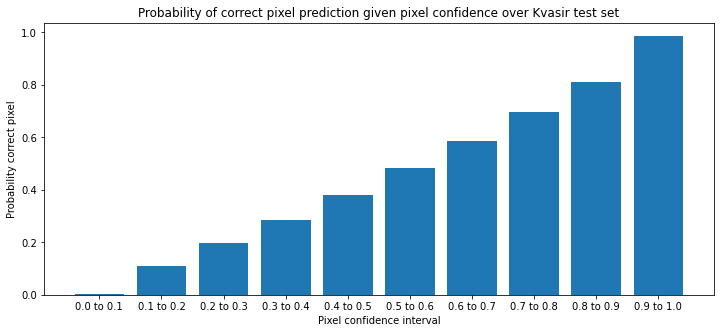

In [ ]:
nr_bins = 10

bins_counter, bins_true = bin_probability(model, test_loader, nr_bins=nr_bins)
probs = [bins_true[i] / bins_counter[i] for i in range(nr_bins)]
x_labels = [str(round((1/nr_bins) * i, 1)) + " to " + str(round((1/nr_bins) * (i+1), 1)) for i in range(nr_bins)]

# Plotting
fig = plt.figure(figsize = (12, 5))
plt.bar(x_labels, probs)
plt.ylabel("Probability correct pixel")
plt.xlabel("Pixel confidence interval")
plt.title("Probability of correct pixel prediction given pixel confidence over Kvasir test set")
plt.show()

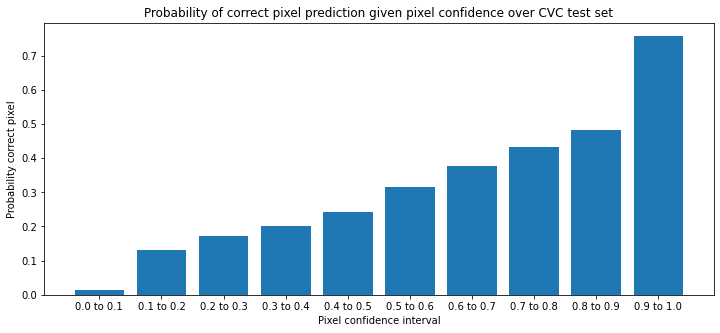

In [ ]:
bins_counter, bins_true = bin_probability(model, cvc_test_loader, nr_bins=nr_bins)
probs = [bins_true[i] / bins_counter[i] for i in range(nr_bins)]
x_labels = [str(round((1/nr_bins) * i, 1)) + " to " + str(round((1/nr_bins) * (i+1), 1)) for i in range(nr_bins)]

# Plotting
fig = plt.figure(figsize = (12, 5))
plt.bar(x_labels, probs)
plt.ylabel("Probability correct pixel")
plt.xlabel("Pixel confidence interval")
plt.title("Probability of correct pixel prediction given pixel confidence over CVC test set")
plt.show()

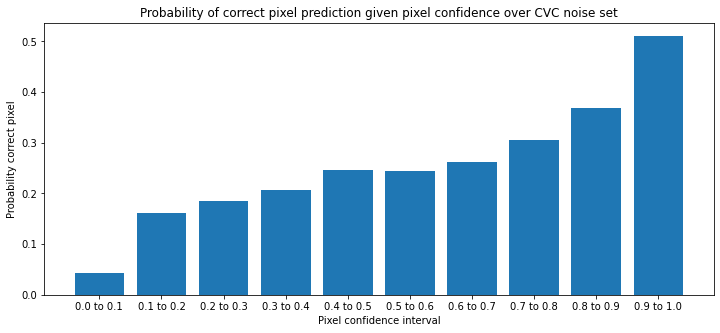

In [ ]:
bins_counter, bins_true = bin_probability(model, cvc_noise_loader, nr_bins=nr_bins)
probs = [bins_true[i] / bins_counter[i] for i in range(nr_bins)]
x_labels = [str(round((1/nr_bins) * i, 1)) + " to " + str(round((1/nr_bins) * (i+1), 1)) for i in range(nr_bins)]

# Plotting
fig = plt.figure(figsize = (12, 5))
plt.bar(x_labels, probs)
plt.ylabel("Probability correct pixel")
plt.xlabel("Pixel confidence interval")
plt.title("Probability of correct pixel prediction given pixel confidence over CVC noise set")
plt.show()

### Model confidence samples

In [ ]:
#plot model confidence examples
def plot_model_pred(model, dataset, idx=None):
    if idx==None:
        idx = random.randint(0, len(dataset))

    model.eval()
    image, label = dataset[idx]
    image, label = image.to(device), label.to(device)
    output = model(torch.unsqueeze(image, dim=0))
    output = torch.sigmoid(output)

    f, axarr = plt.subplots(1, 3, figsize=(25, 8))
    axarr[0].imshow(T.functional.to_pil_image(image.cpu()))
    axarr[0].set_title("Image")
    axarr[0].axis('off')
    axarr[1].imshow(T.functional.to_pil_image(label.cpu()), cmap='gray')
    axarr[1].set_title("Label")
    axarr[1].axis('off')
    axarr[2].imshow(T.functional.to_pil_image(torch.squeeze(output).cpu()), cmap='gray')
    axarr[2].set_title("Prediction")
    axarr[2].axis('off')
    plt.show()

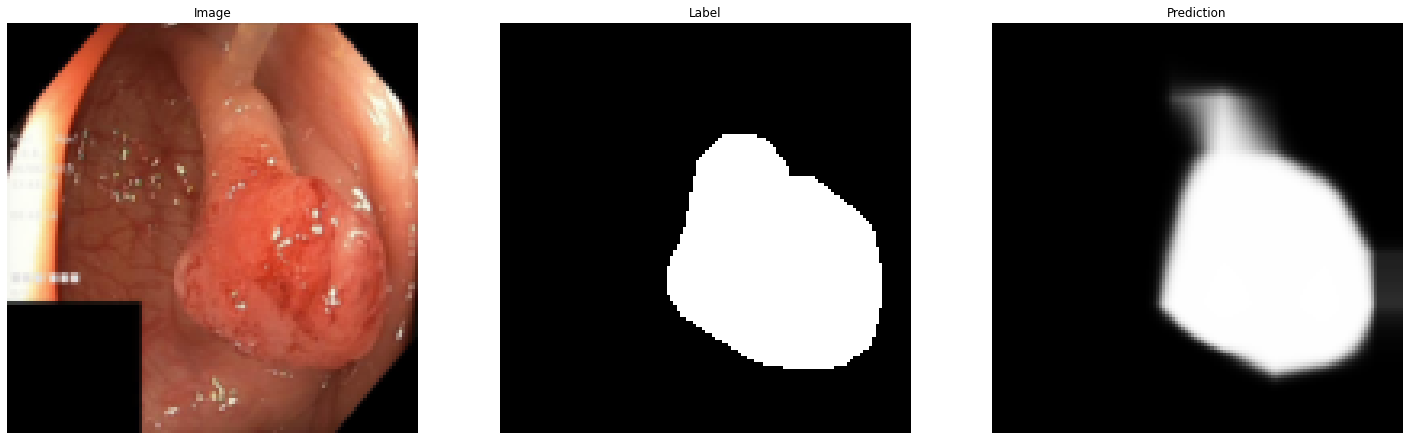

In [ ]:
plot_model_pred(model, test_dataset)

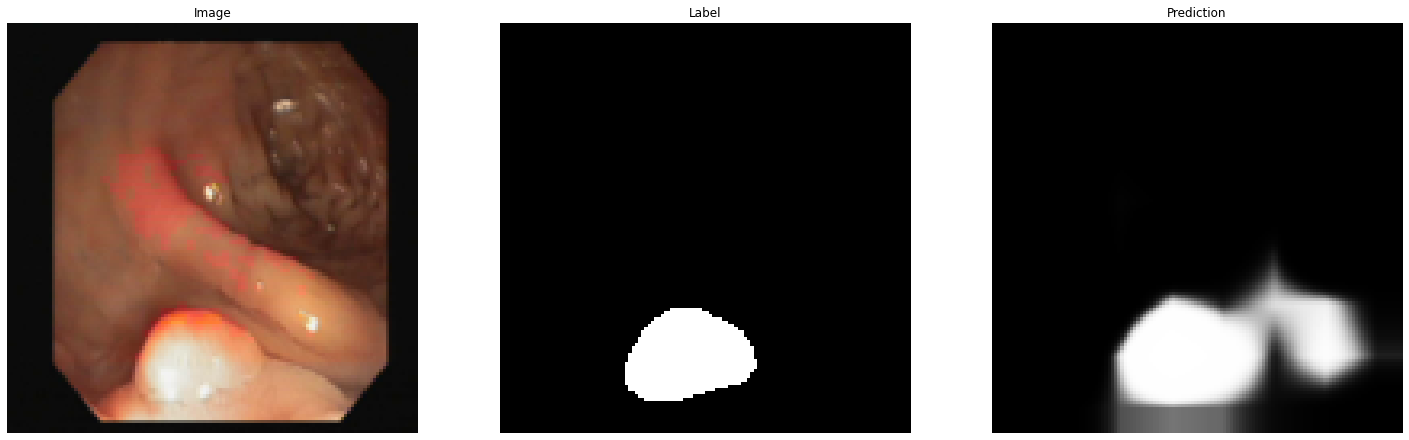

In [ ]:
plot_model_pred(model, cvc_test_dataset)

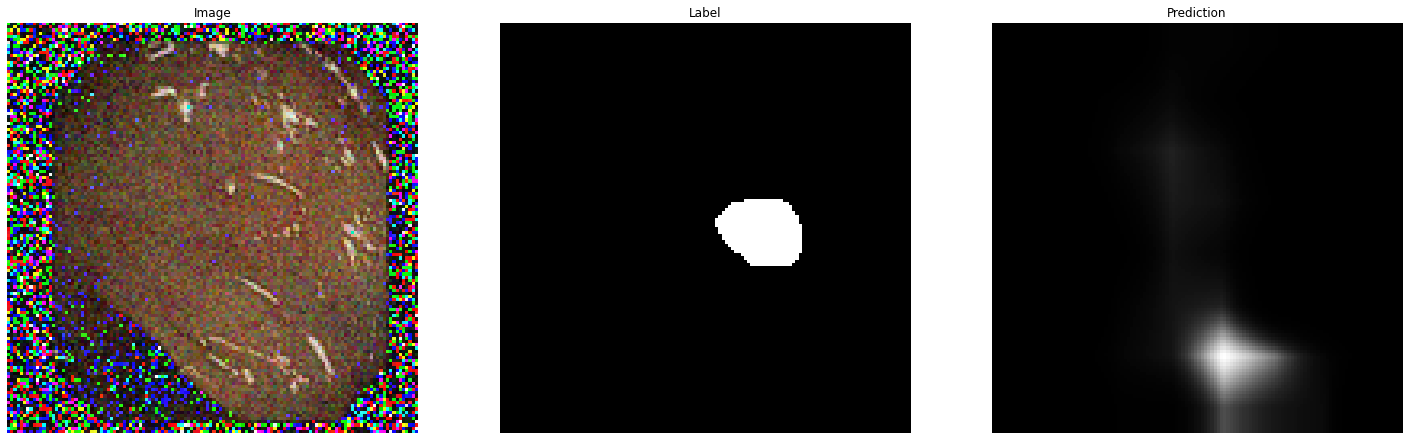

In [ ]:
plot_model_pred(model, cvc_noise_dataset)

## Monte Carlo Dropout

### Monte Carlo Dropout Functions

In [ ]:
def enable_mc_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [ ]:
def get_mc_confidence(model, images, n=nr_mc_samples):
    model.eval()
    enable_mc_dropout(model)
    outputs = []

    for i in range(n):
        output = model(images)
        output = torch.sigmoid(output)
        outputs.append(output)

    outputs = torch.stack(outputs, dim=0)
    output = torch.mean(outputs, dim=0)
    variance = torch.var(outputs, unbiased=False, dim=0)

    return output, variance

In [ ]:
#plot model confidence examples
def plot_mc_confidence(model, dataset, idx=None):
    if idx==None:
        idx = random.randint(0, len(dataset))

    image, label = dataset[idx]
    image, label = image.to(device), label.to(device)
    output, variance = get_mc_confidence(model, torch.unsqueeze(image, dim=0))

    f, axarr = plt.subplots(1, 4, figsize=(25, 8))
    axarr[0].imshow(T.functional.to_pil_image(image.cpu()))
    axarr[0].set_title("Image")
    axarr[0].axis('off')
    axarr[1].imshow(T.functional.to_pil_image(label.cpu()), cmap='gray')
    axarr[1].set_title("Label")
    axarr[1].axis('off')
    axarr[2].imshow(T.functional.to_pil_image(torch.squeeze(output).cpu()), cmap='gray')
    axarr[2].set_title("Prediction (pixel mean)")
    axarr[2].axis('off')
    axarr[3].imshow(T.functional.to_pil_image(torch.squeeze(variance).cpu()), cmap='gray')
    axarr[3].set_title("Pixel variance")
    axarr[3].axis('off')
    plt.show()

In [ ]:
def get_model_conf_var(model, data_loader):
    model.eval()

    #Model confidence
    model_confidence = []
    corrects = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            output = torch.sigmoid(output)
            model_confidence.append(output.cpu())

            pred = torch.round(output)
            correct = pred == labels
            corrects.append(correct.cpu())

    model_confidence = torch.cat(model_confidence, dim=0)
    corrects = torch.cat(corrects, dim=0)

    #Monte Carlo Dropout
    enable_mc_dropout(model)
    variances = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output, variance = get_mc_confidence(model, images)
            variances.append(variance.cpu())

    variances = torch.cat(variances, dim=0)

    return model_confidence, variances, corrects

### Monte Carlo bins

In [ ]:
def bin_variance(model, data_loader, nr_bins):
    bins_counter = [0 for i in range(nr_bins)]
    bins_true = [0 for i in range(nr_bins)]

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            output, variance = get_mc_confidence(model, images)
            pred = torch.round(output)
            correct = pred == labels

            bin_index = torch.ceil(variance / (0.06/nr_bins)) - 1

            for bin in range(nr_bins):
                bins_counter[bin] += int((bin_index == bin).sum())
                bins_true[bin] += int(correct[(bin_index == bin)].sum())

    return bins_counter, bins_true

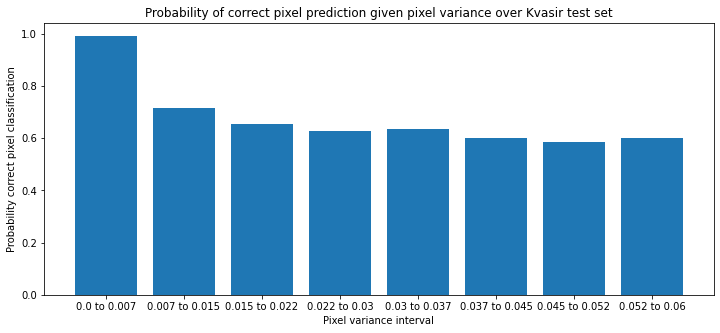

In [ ]:
nr_bins = 8

bins_counter, bins_true = bin_variance(model, test_loader, nr_bins=nr_bins)
probs = [bins_true[i] / (bins_counter[i]+0.001) for i in range(nr_bins)]
x_labels = [str(round((0.06/nr_bins) * i, 3)) + " to " + str(round((0.06/nr_bins) * (i+1), 3)) for i in range(nr_bins)]

# Plotting
fig = plt.figure(figsize = (12, 5))
plt.bar(x_labels, probs)
plt.ylabel("Probability correct pixel classification")
plt.xlabel("Pixel variance interval")
plt.title("Probability of correct pixel prediction given pixel variance over Kvasir test set")
plt.show()

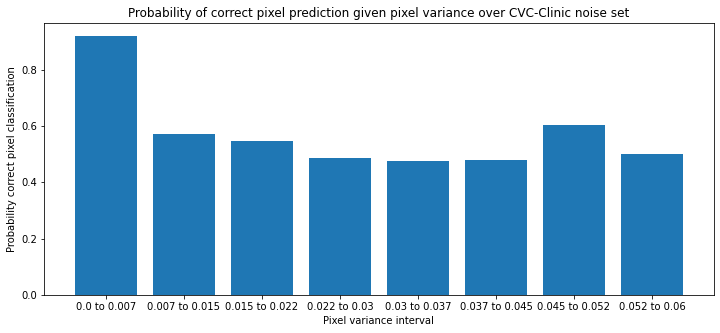

In [ ]:
nr_bins = 8

bins_counter, bins_true = bin_variance(model, cvc_noise_loader, nr_bins=nr_bins)
probs = [bins_true[i] / (bins_counter[i]+0.001) for i in range(nr_bins)]
x_labels = [str(round((0.06/nr_bins) * i, 3)) + " to " + str(round((0.06/nr_bins) * (i+1), 3)) for i in range(nr_bins)]

# Plotting
fig = plt.figure(figsize = (12, 5))
plt.bar(x_labels, probs)
plt.ylabel("Probability correct pixel classification")
plt.xlabel("Pixel variance interval")
plt.title("Probability of correct pixel prediction given pixel variance over CVC-Clinic noise set")
plt.show()

### Plot Monte Carlo variance

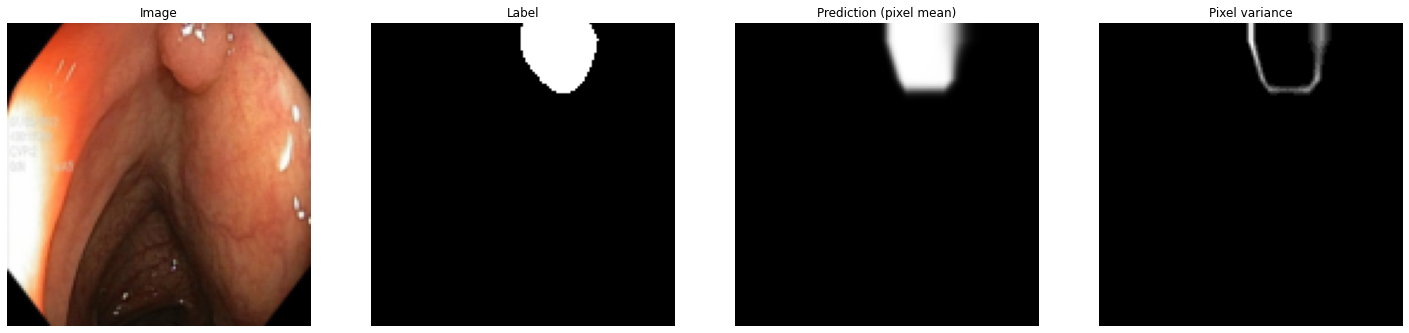

In [ ]:
plot_mc_confidence(model, test_dataset)

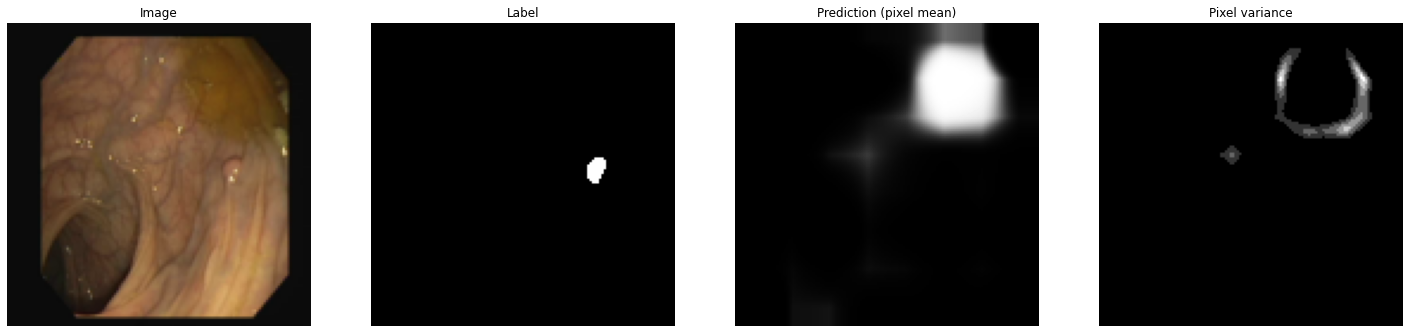

In [ ]:
plot_mc_confidence(model, cvc_test_dataset)

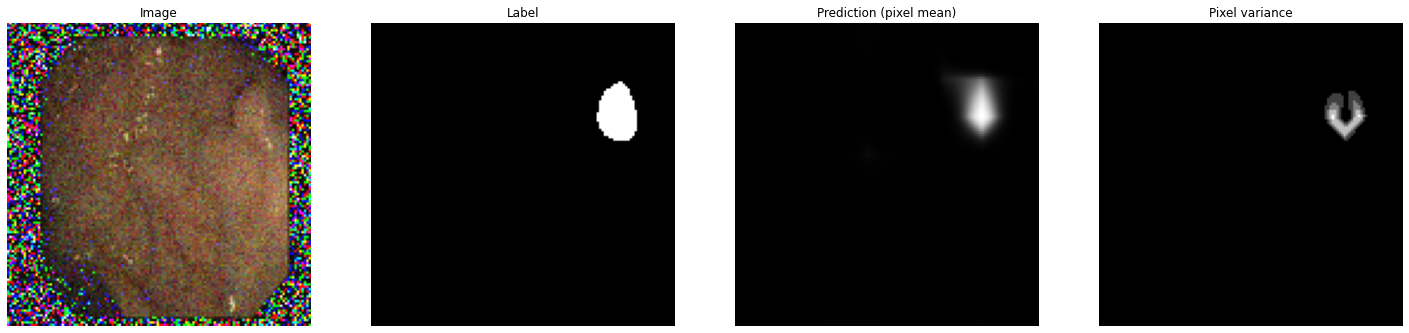

In [ ]:
plot_mc_confidence(model, cvc_noise_dataset)

### Relation Model confidence and Monte Carlo Dropout

In [ ]:
model_confidence, variances, corrects = get_model_conf_var(model, test_loader)

In [ ]:
def plot_conf_var(model_confidence, variances, corrects):
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x=model_confidence.view(-1), y=variances.view(-1), alpha=0.1, hue=corrects.view(-1), palette=['r', 'g'])

    plt.legend(["Correctly classified pixels", "Incorrectly classified pixels"])
    plt.title("Relation model confidence and Monte Carlo Dropout variance on Kvasir-SEG test dataset")
    plt.xlabel("Pixel value (Model confidence)")
    plt.ylabel("Pixel variance (Monte Carlo Dropout)")

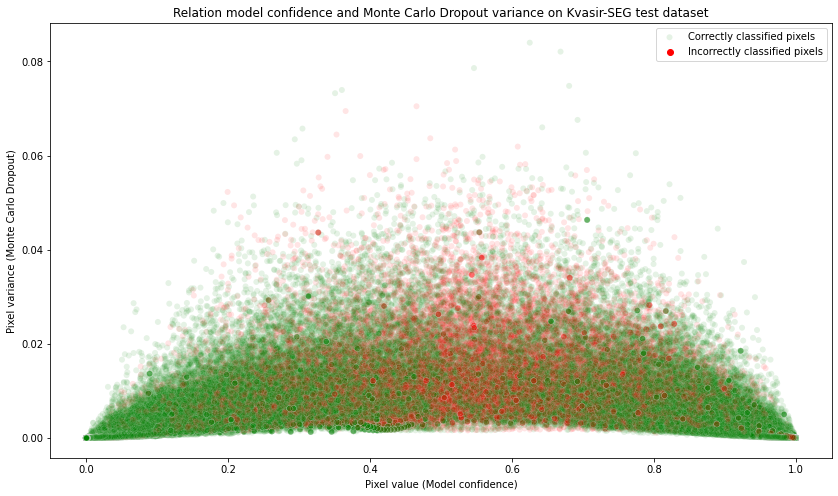

In [ ]:
plot_conf_var(model_confidence, variances, corrects)

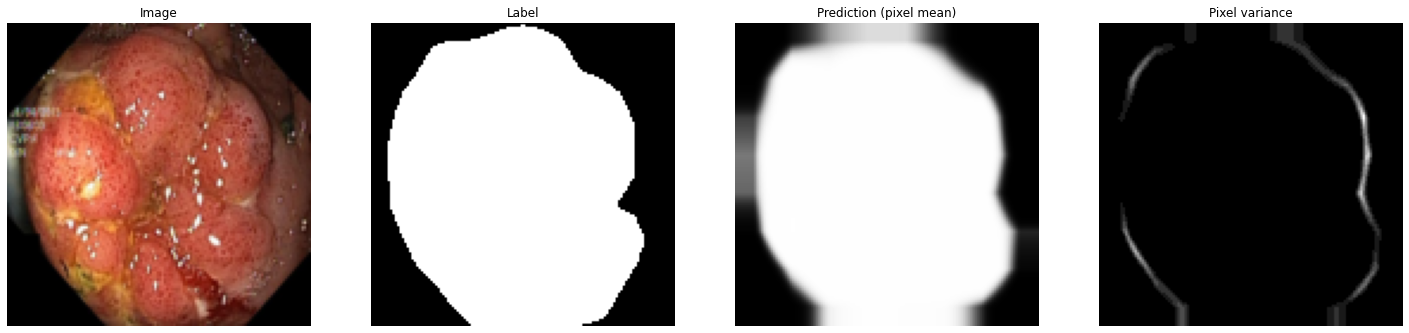

In [ ]:
plot_mc_confidence(model, test_dataset, 74)

## Out-of-distribution detectoin with VAE

### VAE model & training functions

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, channels):
        super(Encoder, self).__init__()

        #Construct Conv blocks
        layers = []
        for i in range(len(channels)-1):
            layers.append(self.conv_block(channels[i], channels[i+1]))

        self.conv_blocks = nn.Sequential(*layers)
        self.fc_1 = nn.Linear(channels[-1]*8*8, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(hidden_dim, latent_dim)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2))


    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc_1(x))
        mu = self.fc_mu(x)
        log_sigma = self.fc_sigma(x)

        return mu, log_sigma

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, channels):
        super(Decoder, self).__init__()
        self.channels = channels
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, channels[0]*8*8)

        #Construct Conv blocks
        layers = []
        for i in range(len(channels)-1):
            layers.append(self.deconv_block(channels[i], channels[i+1]))

        self.deconv_blocks = nn.Sequential(*layers)


    def deconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1))


    def forward(self, x):
        x = torch.relu(self.fc_hidden1(x))
        x = self.fc_hidden2(x)
        x = x.view(-1, self.channels[0], 8, 8)

        x = self.deconv_blocks(x)
        x_recon = torch.sigmoid(x)

        return x_recon

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mu, log_sigma = self.encoder(x)
        z = self.reparameterization(mu, log_sigma)
        x_recon = self.decoder(z)

        return x_recon, mu, log_sigma

    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma).to(device)
        z = mu + sigma * epsilon

        return z

In [ ]:
def vae_loss(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss

    return total_loss, reconstr_loss, kl_loss

In [ ]:
def train_vae(model, nr_epochs, optimizer, train_loader, loss_function):
    model.train()

    for epoch in range(nr_epochs):
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0

        for image, _ in train_loader:
            image = image.to(device)

            optimizer.zero_grad()

            image_recon, mu, log_sigma = model(image)
            loss, reconstr_loss, kl_loss = loss_function(image, image_recon, mu, log_sigma)

            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()

            loss.backward()
            optimizer.step()

        if (epoch+1)%25==0:
            print("\tEpoch", epoch + 1, "\tLoss: ",
                  round(overall_loss), "\tReconstruction Loss:",
                  round(overall_reconstr_loss), "\tKL Loss:",
                  round(overall_kl_loss))

### Train VAE

In [ ]:
hidden_dim = 128
latent_dim = 32

encoder = Encoder(hidden_dim, latent_dim, [3, 16, 24, 32, 40])
decoder = Decoder(latent_dim, hidden_dim, [40, 32, 24, 16, 3])
gen_model = VAE(encoder=encoder, decoder=decoder).to(device)

optimizer = torch.optim.Adam(gen_model.parameters(), lr=1.4e-3)

In [ ]:
train_vae(gen_model, 400, optimizer, train_loader, loss_function=vae_loss)

	Epoch 25 	Loss:  433283 	Reconstruction Loss: 411523 	KL Loss: 21760
	Epoch 50 	Loss:  313127 	Reconstruction Loss: 291087 	KL Loss: 22040
	Epoch 75 	Loss:  271296 	Reconstruction Loss: 249097 	KL Loss: 22199
	Epoch 100 	Loss:  229115 	Reconstruction Loss: 206559 	KL Loss: 22556
	Epoch 125 	Loss:  212748 	Reconstruction Loss: 190538 	KL Loss: 22210
	Epoch 150 	Loss:  205150 	Reconstruction Loss: 182807 	KL Loss: 22343
	Epoch 175 	Loss:  196877 	Reconstruction Loss: 175257 	KL Loss: 21620
	Epoch 200 	Loss:  186314 	Reconstruction Loss: 164265 	KL Loss: 22049
	Epoch 225 	Loss:  178303 	Reconstruction Loss: 157433 	KL Loss: 20870
	Epoch 250 	Loss:  169269 	Reconstruction Loss: 148916 	KL Loss: 20353
	Epoch 275 	Loss:  167410 	Reconstruction Loss: 147125 	KL Loss: 20285
	Epoch 300 	Loss:  163840 	Reconstruction Loss: 143620 	KL Loss: 20220
	Epoch 325 	Loss:  161135 	Reconstruction Loss: 141568 	KL Loss: 19567
	Epoch 350 	Loss:  162734 	Reconstruction Loss: 143049 	KL Loss: 19685
	Epoch 37

### Reconstruction

In [ ]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = image_resolution[0] * image_resolution[1] * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss

    return elbo, reconstr_loss, kl_loss

In [ ]:
def compute_elbos(model, data_loader):
    model.eval()

    x_originals = []
    x_recons = []
    elbos = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)

            x_recon, mu, log_sigma = model(x)
            elbo, reconstr_loss, kl_loss = elbo_elementwise(x.view(x.size(0), -1), x_recon.view(x_recon.size(0), -1), mu, log_sigma)

            x_originals.append(x.cpu())
            x_recons.append(x_recon.cpu())
            elbos.append(elbo.cpu())

    elbos = torch.cat(elbos)
    x_originals = torch.cat(x_originals)
    x_recons = torch.cat(x_recons)

    return x_originals, x_recons, elbos

In [ ]:
def show_recon(x_originals, x_recons, elbos):
    random_list = [random.randint(0, len(x_originals)) for i in range(2)]

    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    for idx in range(2):
        ax[0, idx].imshow(T.functional.to_pil_image(x_originals[random_list[idx]]))
        ax[0, idx].axis('off')
        ax[0, idx].set_title("Original image")
        ax[1, idx].imshow(T.functional.to_pil_image(x_recons[random_list[idx]]))
        ax[1, idx].axis('off')
        ax[1, idx].set_title(f"Reconstructed image with elbo: {int(elbos[random_list[idx]])}")
    plt.show()

In [ ]:
train_x_originals, train_x_recons, train_elbos = compute_elbos(gen_model, train_loader)
test_x_originals, test_x_recons, test_elbos = compute_elbos(gen_model, test_loader)
cvc_x_originals, cvc_x_recons, cvc_elbos = compute_elbos(gen_model, cvc_test_loader)
cvc_noise_x_originals, cvc_noise_x_recons, cvc_noise_elbos = compute_elbos(gen_model, cvc_noise_loader)

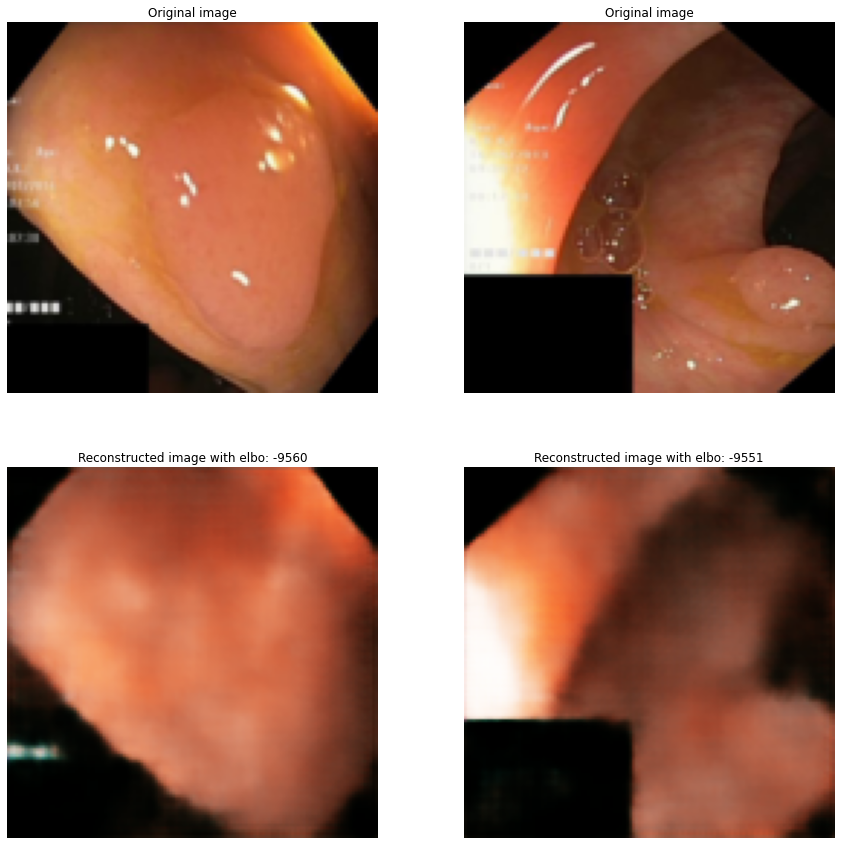

In [ ]:
show_recon(train_x_originals, train_x_recons, train_elbos)

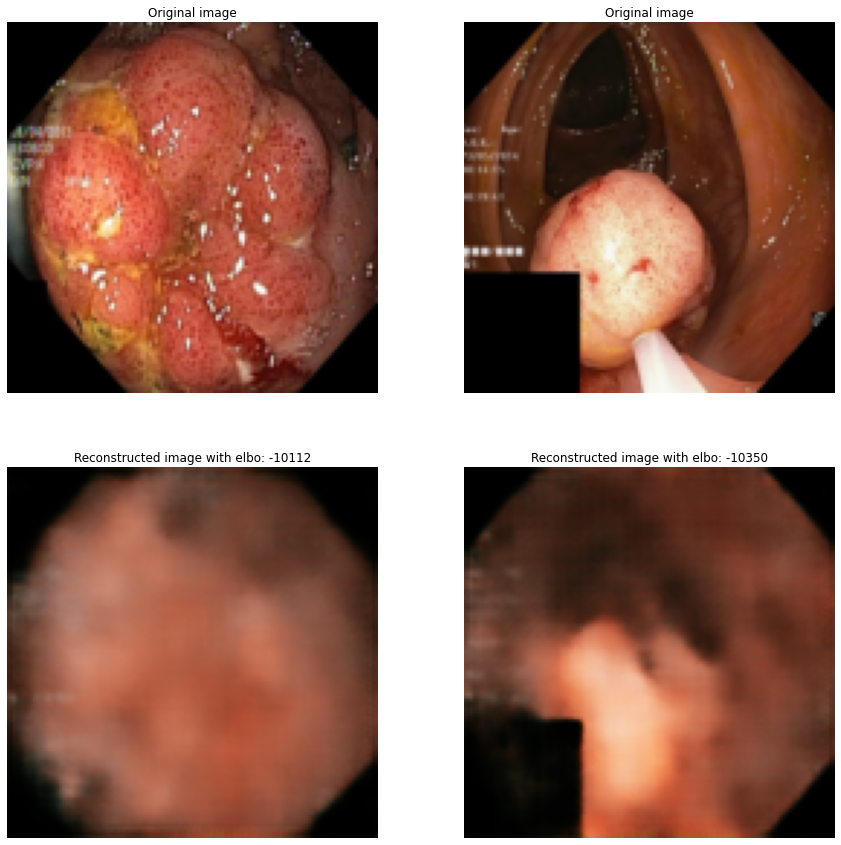

In [ ]:
show_recon(test_x_originals, test_x_recons, test_elbos)

### Out-of-distribution detection

In [ ]:
def density_plot(train, test, cvc, cvc_noise):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train, shade=True, color="g")
    sns.kdeplot(test, shade=True, color="y")
    sns.kdeplot(cvc, shade=True, color="b")
    sns.kdeplot(cvc_noise, shade=True, color="r")
    plt.legend(["Kvasir training set", "Kvasir test set", "CVC test set", "CVC noise set"], loc='upper left')
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

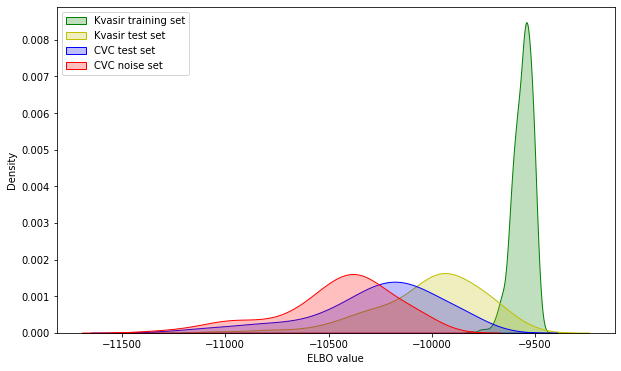

In [ ]:
density_plot(train_elbos, test_elbos, cvc_elbos, cvc_noise_elbos)

In [ ]:
#Get the dice scores for each dataset
test_dice_list = dice_scores(model, test_loader)
cvc_dice_list = dice_scores(model, cvc_test_loader)
cvc_noise_dice_list = dice_scores(model, cvc_noise_loader)

In [ ]:
def scatter_plot(test_elbos, cvc_elbos, cvc_noise_elbos, test_dice_list, cvc_dice_list, cvc_noise_dice_list):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=test_elbos, y=test_dice_list, color="y")
    sns.scatterplot(x=cvc_elbos, y=cvc_dice_list, color="b")
    sns.scatterplot(x=cvc_noise_elbos, y=cvc_noise_dice_list, color="r")

    #Regression lines
    all_elbos = np.concatenate((test_elbos, cvc_elbos, cvc_noise_elbos))
    all_dice_list = np.concatenate((test_dice_list, cvc_dice_list, cvc_noise_dice_list))
    m, b = np.polyfit(all_elbos, all_dice_list, 1)
    plt.plot(all_elbos, m * all_elbos + b, color="g")

    plt.legend(["Regression line", "Kvasir test set", "CVC test set", "CVC noise set"], loc='lower left')
    plt.xlabel("ELBO value")
    plt.ylabel("Dice coefficient")

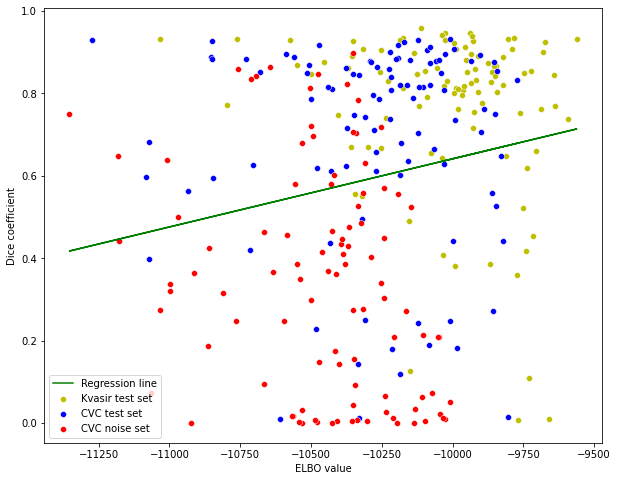

In [ ]:
scatter_plot(test_elbos, cvc_elbos, cvc_noise_elbos, test_dice_list, cvc_dice_list, cvc_noise_dice_list)

## Legacy: Out-of-distribution detectoin with Normalizing Flow

### Imports

In [ ]:
!git clone https://github.com/tatsy/normalizing-flows-pytorch.git

Cloning into 'normalizing-flows-pytorch'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 407 (delta 224), reused 303 (delta 124), pack-reused 0
Receiving objects: 100% (407/407), 7.46 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (224/224), done.


In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np

%cd normalizing-flows-pytorch/
from flows.modules import Logit, ActNorm, Compose, InvertibleConv1x1
from flows.squeeze import Squeeze2d, Unsqueeze2d
from flows.coupling import AffineCoupling
%cd ../

/content/normalizing-flows-pytorch
/content


### Glow model

In [ ]:
class Glow(nn.Module):
    def __init__(self, nr_layers, image_shape):
        super(Glow, self).__init__()

        mu = torch.zeros(np.prod(image_shape), dtype=torch.float32, device=device)
        covar = torch.eye(np.prod(image_shape), dtype=torch.float32, device=device)
        self.normal = MultivariateNormal(mu, covar)

        self.image_shape = image_shape
        layers = []
        layers.append(Logit(eps=0.01))

        mid_image_shape = image_shape
        while mid_image_shape[-1] > 8:
            for i in range(nr_layers):
                #Checkerboard masking
                layers.append(ActNorm(mid_image_shape))
                layers.append(InvertibleConv1x1(mid_image_shape[0]))
                layers.append(AffineCoupling(mid_image_shape, masking='checkerboard', odd=i % 2 != 0))

            #Squeeze
            layers.append(Squeeze2d(odd=False))
            mid_image_shape = (mid_image_shape[0] * 4, mid_image_shape[1] // 2, mid_image_shape[2] // 2)

            #Channel-wise masking
            for i in range(nr_layers):
                layers.append(ActNorm(mid_image_shape))
                layers.append(InvertibleConv1x1(mid_image_shape[0]))
                layers.append(AffineCoupling(mid_image_shape, masking='channelwise', odd=i % 2 != 0))

        #Checkerboard masking (lowest resolution)
        for i in range(nr_layers + 1):
            layers.append(ActNorm(mid_image_shape))
            layers.append(InvertibleConv1x1(mid_image_shape[0]))
            layers.append(AffineCoupling(mid_image_shape, masking='checkerboard', odd=i % 2 != 0))

        #Restore to original size
        while mid_image_shape[1] != image_shape[1] or mid_image_shape[2] != image_shape[2]:
            #Unsqueeze
            layers.append(Unsqueeze2d(odd=False))
            mid_image_shape = (mid_image_shape[0] // 4, mid_image_shape[1] * 2, mid_image_shape[2] * 2)

        self.net = Compose(layers)


    def forward(self, z):
        log_df_dz = torch.zeros(z.size(0)).type_as(z).to(device)

        return self.net(z, log_df_dz)


    def backward(self, z):
        log_df_dz = torch.zeros(z.size(0)).type_as(z).to(device)

        return self.net.backward(z, log_df_dz)

In [ ]:
def train_gen(nr_epochs, gen_model, optimizer, gen_train_loader):
    deq_constant = -np.prod(gen_model.image_shape) * np.log(1/255)
    losses = []

    for epoch in range(nr_epochs):
        epoch_losses = []

        for image, _ in gen_train_loader:
            image = image.to(device).contiguous()
            image += torch.rand_like(image) / 255

            z, log_det_jacob = gen_model(image)
            z = z.view(image.size(0), -1)

            loss = -1.0 * torch.mean(gen_model.normal.log_prob(z) + log_det_jacob) + deq_constant
            epoch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(np.average(epoch_losses))

        print(f"Epoch: {epoch+1}, loss: {round(np.average(epoch_losses))}")

    return losses

### Training

In [ ]:
gen_model = Glow(nr_layers=1, image_shape=(3, *image_resolution)).to(device)
optimizer = torch.optim.Adam(gen_model.parameters())

In [ ]:
losses = train_gen(50, gen_model, optimizer, train_loader)

Epoch: 1, loss: 55806
Epoch: 2, loss: 50241
Epoch: 3, loss: 45860
Epoch: 4, loss: 41831
Epoch: 5, loss: 38575
Epoch: 6, loss: 36396
Epoch: 7, loss: 35233
Epoch: 8, loss: 34501
Epoch: 9, loss: 34099
Epoch: 10, loss: 33688
Epoch: 11, loss: 33378
Epoch: 12, loss: 33115
Epoch: 13, loss: 32896
Epoch: 14, loss: 32683
Epoch: 15, loss: 32463
Epoch: 16, loss: 32227
Epoch: 17, loss: 32138
Epoch: 18, loss: 31853
Epoch: 19, loss: 31591
Epoch: 20, loss: 31461
Epoch: 21, loss: 31282
Epoch: 22, loss: 31102
Epoch: 23, loss: 30906
Epoch: 24, loss: 30747
Epoch: 25, loss: 30572
Epoch: 26, loss: 30435
Epoch: 27, loss: 30346
Epoch: 28, loss: 30153
Epoch: 29, loss: 30040
Epoch: 30, loss: 29960
Epoch: 31, loss: 29780
Epoch: 32, loss: 29639
Epoch: 33, loss: 29611
Epoch: 34, loss: 29517
Epoch: 35, loss: 29308
Epoch: 36, loss: 29225
Epoch: 37, loss: 29115
Epoch: 38, loss: 29007
Epoch: 39, loss: 28999
Epoch: 40, loss: 28857
Epoch: 41, loss: 28831
Epoch: 42, loss: 28670
Epoch: 43, loss: 28555
Epoch: 44, loss: 284

### Evaluating

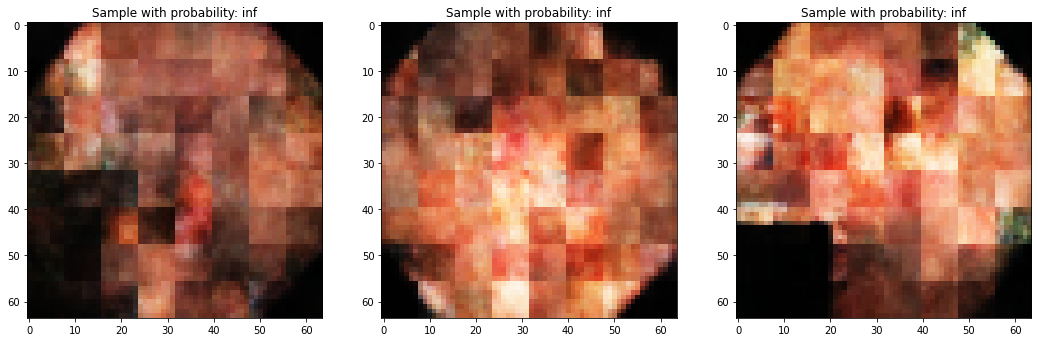

In [ ]:
def show_samples(gen_model, n):
    z = gen_model.normal.sample([n])
    z = z.to(device)
    image, log_det_jacob = gen_model.backward(z.view(-1, *gen_model.image_shape))
    log_p = gen_model.normal.log_prob(z) - log_det_jacob
    prob = torch.exp(log_p)

    #Plotting
    f, axarr = plt.subplots(1, n, figsize=(6*n, 6))
    for idx in range(n):
        axarr[idx].imshow(T.functional.to_pil_image(image[idx].cpu()))
        axarr[idx].set_title(f"Sample with probability: {prob[idx]}")
    plt.show()


show_samples(gen_model, 3)

tensor([-20613.6523, -19317.4512, -20030.7109], device='cuda:0')
tensor([37659.4258, 35879.6328, 38171.1680], device='cuda:0')


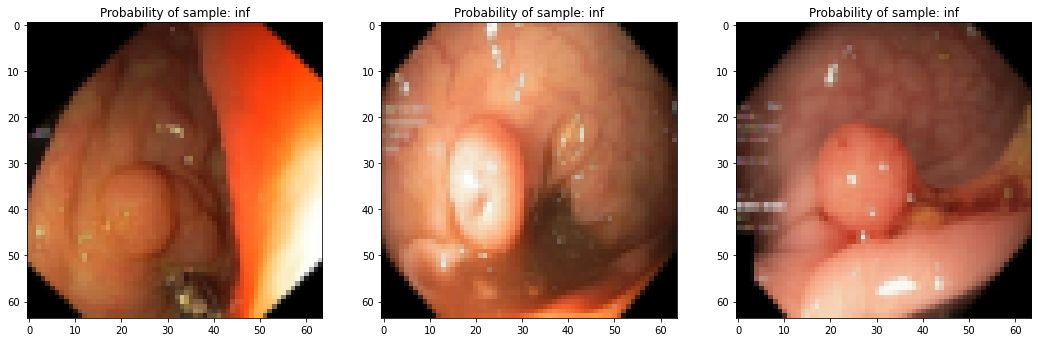

In [ ]:
def eval_samples(gen_model, dataset, n, idx=None):
    if idx==None:
        idx = [random.randint(0, len(dataset)) for i in range(n)]

    images = torch.stack([dataset[i][0] for i in idx])

    with torch.no_grad():
        z, log_det_jacob = gen_model(images.to(device))
        log_p_images = gen_model.normal.log_prob(z.view(n, -1)) + log_det_jacob
    probs = torch.exp(log_p_images)

    #Plotting
    f, axarr = plt.subplots(1, n, figsize=(6*n, 6))
    for i in range(n):
        axarr[i].imshow(T.functional.to_pil_image(images[i].cpu()))
        axarr[i].set_title(f"Probability of sample: {probs[i]}")
    plt.show()

eval_samples(gen_model, train_dataset, 3)

tensor([-66785100., -66496940., -52928932.], device='cuda:0')


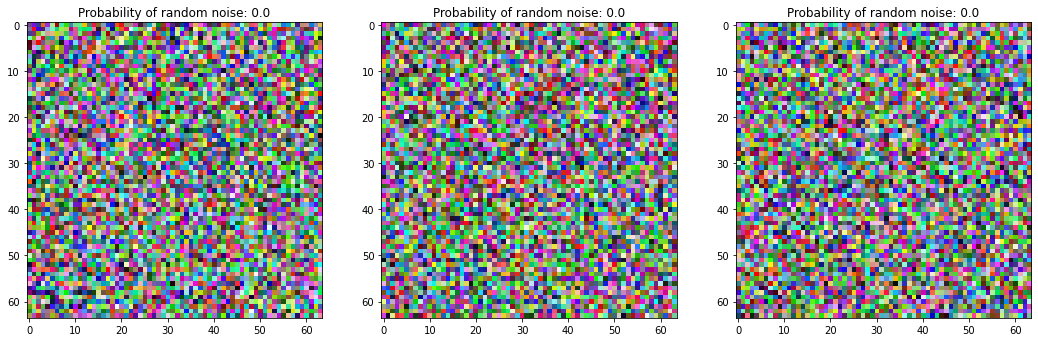

In [ ]:
def eval_noise(gen_model, n):
    images = torch.randn((n, *gen_model.image_shape))

    with torch.no_grad():
        z, log_det_jacob = gen_model(images.to(device))
        log_p_images = gen_model.normal.log_prob(z.view(n, -1)) #+ log_det_jacob
        print(gen_model.normal.log_prob(z.view(n, -1)))
    probs = torch.exp(log_p_images)

    #Plotting
    f, axarr = plt.subplots(1, n, figsize=(6*n, 6))
    for i in range(n):
        axarr[i].imshow(T.functional.to_pil_image(images[i].cpu()))
        axarr[i].set_title(f"Probability of random noise: {probs[i]}")
    plt.show()

eval_noise(gen_model, 3)